# **The Simpsons Episode Finder**

---
## **Introduction**

As a big fan of *The Simpsons*, I often find myself wanting to rewatch a specific episode based on a vague memory of its plot. However, identifying the exact episode can be complicated. This motivated me to create a web application that can help locate episodes based on that vague memory.

While researching how to make this idea a reality, I came across with this dataset on Kaggle: [The Simpsons Dataset](https://www.kaggle.com/datasets/prashant111/the-simpsons-dataset).

This dataset seemed like a perfect starting point for training a model. It includes episode metadata, full script lines, and other details, which can be leveraged to build the system.

### **What kind of System is This?**

The first thing I asked myself is what type of task I'm trying to solve, and search for references.

- **Recommendation system?**: Suggesting episodes based on input descriptions.
- **Classification task?**: Predicting the correct episode from a fixed set of classes.
- **Text similarity problem?**: Matching user descriptions with episode content.
- **Information retrieval?**: Searching through structured text data to find relevand matches.

It make more sense to me to approach this task as a text similarity problem. I couldn't find a solution that specifically address this problem, which meant venturing into uncharted territory—an exciting challenge for a practitioner 🙃.

### **Feasibility**

The next question I made was "can this really be done?". To determine if the idea was feasible, I identified the following requirements.
1. **Episode metadata**: Season and episode numbers, titles, etc.
2. **Detailed plot descriptions**: Comprehensive summaries or scripts for each episode.
3. **Adequate training data**: A sufficient number of examples to train an effective model.

Upon reviewing the dataset, I thought the situation was favorable:
- Comprehensive metadata for each episode ✅
- Access to full script lines, which provide more detail than simple summaries ✅
- A reasonable dataset size of ~600 episodes ✅

These factors made the project feasible. However, challenges remain:
- Fragmented script lines (individual dialogues rather than summaries).
- Need for significan data preprocessing.

---
## **Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer

import nltk
from nltk.corpus    import stopwords
from nltk.tokenize  import word_tokenize
from nltk.stem      import WordNetLemmatizer
from nltk.corpus    import wordnet

import re
from typing import List, Dict, Any
from IPython.display import clear_output

---
## **Loading the Data**

In [ ]:
episodes_path = '/content/drive/MyDrive/ML Projects/The Simpsons/simpsons_episodes.csv'
scripts_path = '/content/drive/MyDrive/ML Projects/The Simpsons/simpsons_script_lines.csv'

In [ ]:
# Load the scripts data with correct dtypes
scripts_df = pd.read_csv(scripts_path, low_memory=False, dtype={
    'id': 'int64',
    'episode_id': 'int64',
    'number': 'int64',
    'raw_text': str,
    'timestamp_in_ms': str,
    'speaking_line': str,
    'character_id': str,
    'location_id': float,
    'raw_character_text': str,
    'raw_location_text': str,
    'spoken_words': str,
    'normalized_text': str,
    'word_count': str
})

# Convert some columns to more appropriate types
scripts_df['speaking_line'] = scripts_df['speaking_line'] \
                              .map({'true': True, 'false': False})
scripts_df['timestamp_in_ms'] = pd.to_numeric(scripts_df['timestamp_in_ms'],
                                              errors='coerce')
scripts_df['word_count'] = pd.to_numeric(scripts_df['word_count'],
                                         errors='coerce')

# For the episodes file, let's keep it simple
episodes_df = pd.read_csv(episodes_path, low_memory=False)

# Verify the data loaded correctly
print("Scripts DataFrame shape:", scripts_df.shape)
print("Episodes DataFrame shape:", episodes_df.shape)

Scripts DataFrame shape: (158271, 13)
Episodes DataFrame shape: (600, 14)


---
## **System Design**

To address this problem, I explored the use of `sentence-transformers` (SBERT) that, according to its documentation:
> "...is the go-to Python module for accessing, using, and training state-of-the-art text and image embedding models. It can be used to compute embeddings using Sentence Transformer models or to calculate similarity scores using Cross-Encoder models."

Using SBERT, I could do the following:
1. **Semantic Embedding Creation**: Generate embeddings for episode content using script lines metadata.
2. **Similarity Search**: Implement an efficient similarity search mechanism to match user queries with episodes.
3. **Web Application**: Develop a simple interface to take user input and display results.

### **Some key advantages of this approach**

- **Semantic Understanding**: Matches concepts, not just keywords.
- **Fast Retrieval**: Efficient search for relevant episodes.
- **Confidence Scores**: Indicates the likelihood of correctness.
- **Multiple Candidates**: Displays alternative matches if the top result is incorrect.

Then, to build the web application, I could simply do:
- Save processed episodes and embeddings.
- Create a user-friendly web interface with a text input field for queries.
- Display results with relevant metadata in an intuitive format.

### **System Overview**

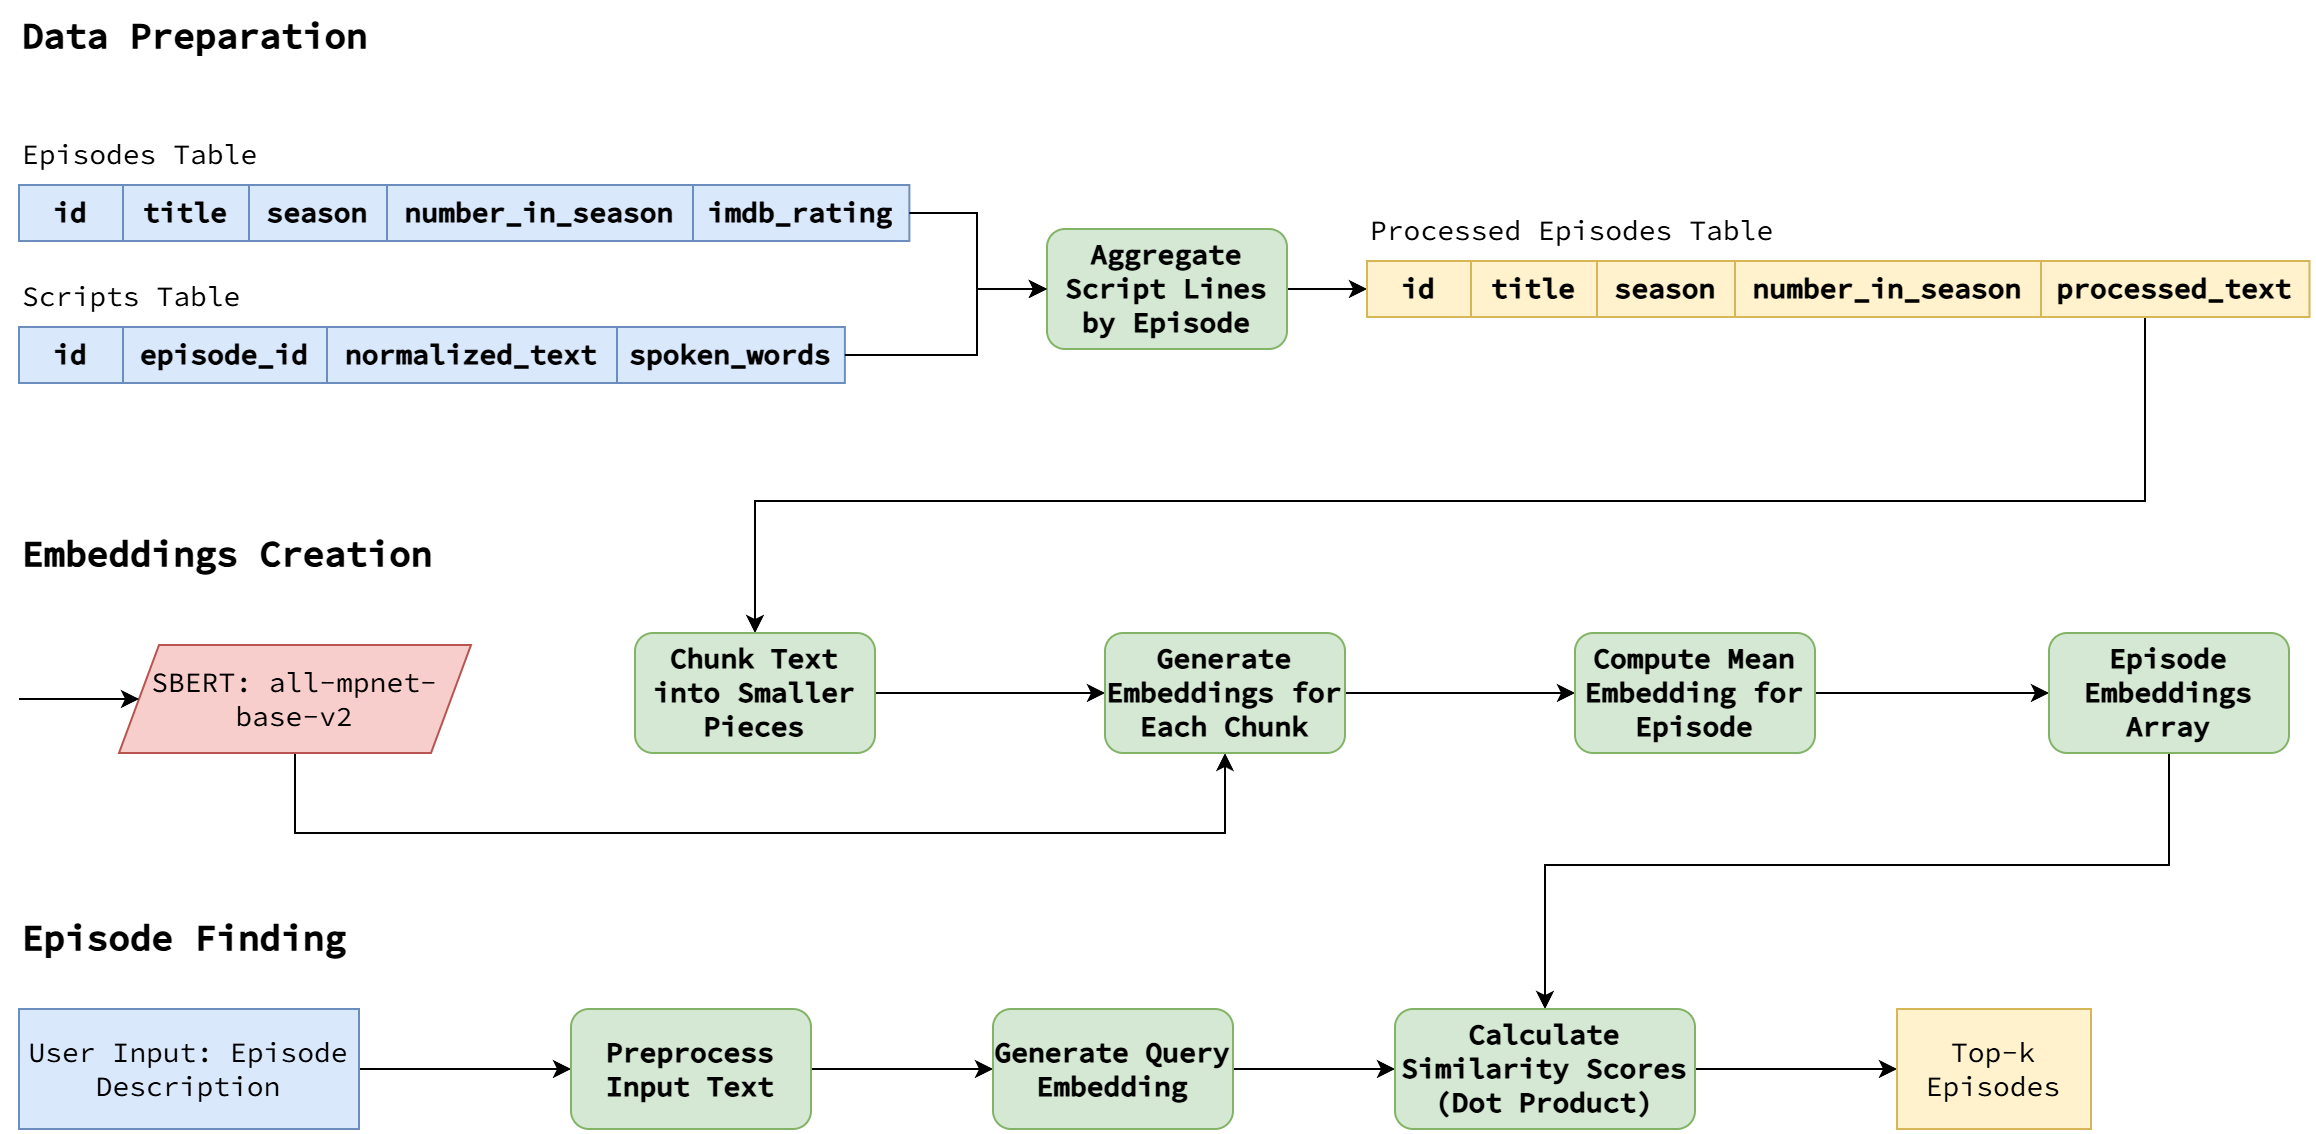

---
## **Implementation**

After a lot of trial and error, I identified key considerations for implementation:
1. **Preprocessing**:
    - **Stopword Removal**: Eliminate common words like "the", "and", "is" to focus on meaningful terms.
    - **Lemmatization/Stemming**: Normalize words to their root forms. This is important because episode scripts may contain variations of the same word (e.g., "run", "runs", "running"). By reducing words to their base forms, we can improve the semantic understanding and matching of the text, leading to better results.
2. **Model Selection**:
    - `all-Min-L6-v2` is fast but struggles with fine-grained distinctions in long texts.
    - `all-mpnet-base-v2` offers better embeddings at the cost of slower processing.
        - `all-mpnet-base-v2` is a version of MPNet fine-tuned specifically for sentence embeddings, provided by the SentenceTransformers library.
3. **Handling Long Texts**:
    - Split scripts into smaller chinks, calculate embeddings for each, and aggregate results (e.g., mean embedding).
4. **Similarity Metrics**:
    - While cosine similarity is straightforward, other options like the dot product may better capture relationships with normalized embeddings.
        - Cosine similarity is more sensitive to the direction of the vectors, but not their magnitude. Since we're primarily interested in the semantic closeness of the embeddings, the dot product is a simpler and more effective choice for our use case.

#### **Class `TextPreprocessor`**
- `__init__`: Initializes the preprocessor with a lemmatizer and a set of English stopwords.
- `get_wordnet_pos(word: str) -> str`: Maps POS tags to WordNet POS tags for better lemmatization.
- `preprocess_text(text: str) -> str`: Performs comprehensive text preprocessing, including:
    - Lowecasing the text.
    - Removing special characters and digits.
    - Tokenizing text.
    - Removing stopwords and lemmatizing tokens.

#### **Class `EpisodeFinder`**
- `__init__(episodes_df: pd.DataFrame, scripts_df: pd.DataFrame)`:
    - Initializes the finder with preprocessed episode data.
    - Loads a `SentenceTransformer` model for generating embeddings.
    - Sets a chunk size for splitting long texts.
    - Creates embeddings for all episodes.
- `_prepare_data(episodes_df: pd.DataFrame, scripts_df: pd.DataFrame) -> pd.DataFrame`:
    - Aggregates script lines per episode.
    - Merges script data with episode metadata.
    - Combines metadata and scripts into a single text field.
    - Applies text preprocessing to the combined text.
- `_chunk_text(text: str) -> List[str]`: Splits texts into chunks that fit within the model's token limit.
- `_create_embeddings()`:
    - Generates embeddings for each episode using text chunks.
    - Aggregates chunk embeddings by calculating their mean to represent the episode.
- `find_episode(description: str, top_k: int = 3) -> List[Dict[str, Any]]`:
    - Preprocess the user-provided description.
    - Encodes the query into an embedding.
    - Calculates similarity scores between the query and episode embeddings.
    - Returns the top `k` most similar episodes, including metadata and a similarity score.

In [ ]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

clear_output()

In [ ]:
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def get_wordnet_pos(self, word: str) -> str:
        """Map POS tag to WordNet POS tag"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {
            "J": wordnet.ADJ,
            "N": wordnet.NOUN,
            "V": wordnet.VERB,
            "R": wordnet.ADV
        }
        # ("J", "N", "V", "R") correspond to the part-of-speech
        # tags used by the WordNet lexical database.
        return tag_dict.get(tag, wordnet.NOUN)

    def preprocess_text(self, text: str) -> str:
        """
        Apply comprehensive text preprocessing
        """
        if pd.isna(text):
            return ""

        # Convert to string and lowercase
        text = str(text).lower()

        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)

        # Tokenize
        tokens = word_tokenize(text)

        # Remove stopwords and lemmatize
        # WordNet's POS tags are more fine-grained and tailored for
        # linguistic analysis, compared to the more generic NLTK tags.
        processed_tokens = []
        for token in tokens:
            if token not in self.stop_words:
                pos = self.get_wordnet_pos(token)
                lemma = self.lemmatizer.lemmatize(token, pos)
                processed_tokens.append(lemma)

        return ' '.join(processed_tokens)

In [ ]:
class EpisodeFinder:
    def __init__(self, episodes_df: pd.DataFrame, scripts_df: pd.DataFrame):
        self.preprocessor = TextPreprocessor()
        self.episodes = self._prepare_data(episodes_df, scripts_df)
        self.model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
        self.chunk_size = 512  # Maximum tokens for the model
        self._create_embeddings()

    def _prepare_data(self, episodes_df: pd.DataFrame, scripts_df: pd.DataFrame) -> pd.DataFrame:
        """
        Prepare and combine episode data with enhanced preprocessing
        """
        # Aggregate script lines per episode
        episode_scripts = scripts_df.groupby('episode_id').agg({
            'normalized_text': lambda x: ' '.join(str(text) for text in x if pd.notna(text))
        }).reset_index()

        # Merge with episode metadata
        full_episodes = episodes_df.merge(
            episode_scripts,
            left_on='id',
            right_on='episode_id'
        )

        # Create combined text with metadata
        full_episodes['combined_text'] = full_episodes.apply(
            lambda row: (
                f"{row['title']} Season {row['season']} "
                f"Episode {row['number_in_season']} "
                f"{row['normalized_text']}"
            ),
            axis=1
        )

        # Preprocess combined text
        full_episodes['processed_text'] = full_episodes['combined_text'].apply(
            self.preprocessor.preprocess_text
        )

        return full_episodes

    def _chunk_text(self, text: str) -> List[str]:
        """
        Split text into chunks that fit within model's token limit
        """
        words = text.split()
        chunks = []
        current_chunk = []
        current_length = 0

        for word in words:
            current_length += len(word) + 1  # +1 for space
            if current_length > self.chunk_size:
                chunks.append(' '.join(current_chunk))
                current_chunk = [word]
                current_length = len(word)
            else:
                current_chunk.append(word)

        if current_chunk:
            chunks.append(' '.join(current_chunk))

        return chunks

    def _create_embeddings(self):
        """
        Create embeddings for each episode using chunking
        """
        all_embeddings = []

        for text in self.episodes['processed_text']:
            chunks = self._chunk_text(text)
            chunk_embeddings = self.model.encode(chunks)
            # Use mean of chunk embeddings as episode embedding
            episode_embedding = np.mean(chunk_embeddings, axis=0)
            all_embeddings.append(episode_embedding)

        self.episode_embeddings = np.array(all_embeddings)

    def find_episode(self, description: str, top_k: int = 3) -> List[Dict[str, Any]]:
        """
        Find most similar episodes to the given description
        """
        # Preprocess the query
        processed_query = self.preprocessor.preprocess_text(description)
        query_embedding = self.model.encode([processed_query])[0]

        # Calculate similarities using dot product
        similarities = np.dot(self.episode_embeddings, query_embedding)

        # Get top matches
        top_indices = np.argsort(similarities)[-top_k:][::-1]

        results = []
        for idx in top_indices:
            episode = self.episodes.iloc[idx]
            results.append({
                'title': episode['title'],
                'season': episode['season'],
                'episode': episode['number_in_season'],
                'similarity_score': float(similarities[idx]),
                'description': episode['normalized_text'][:200] + '...'  # Preview
            })

        return results

In [ ]:
# Initialize finder
finder = EpisodeFinder(episodes_df, scripts_df)

clear_output()

Let's try it out!

In [ ]:
results = finder.find_episode(
    "Lisa is outperformed in everything she does by a new student"
)
for result in results:
    print(f"Season {result['season']} Episode {result['episode']}: {result['title']}")
    print(f"Similarity Score: {result['similarity_score']:.3f}")
    print(f"Preview: {result['description']}\n")

Season 6 Episode 2: Lisa's Rival
Similarity Score: 0.303
Preview: you see marge you see lisa will you keep it down im making a crank phone call to principal skinner uh well as a matter of fact my refrigerator wasnt running you spared me quite a bit of spoilage thank...

Season 10 Episode 7: Lisa Gets an "A"
Similarity Score: 0.302
Preview: why you little-- and may we burn in painful and foul-smelling fire forever and ever aaaaa-- mmmennnnonite minister will be giving a guest sermon next sunday go in peace aaaa-- dont make me come up the...

Season 15 Episode 3: The President Wore Pearls
Similarity Score: 0.300
Preview: ooh boy casino night finally theyll teach our kids the dangers of doubling down on a six i really shouldnt be here -- i have a problem with games of chance i played candyland with maggie and ended up ...



---
## **Saving the model**

In [ ]:
save_path = "/content/drive/MyDrive/ML Projects/The Simpsons/saved_models/episode_finder_model"

In [ ]:
import pickle
from pathlib import Path

def save_finder(finder, save_path: str):
    """
    Save the EpisodeFinder object, including the SentenceTransformer model and embeddings.
    """
    save_dir = Path(save_path)
    save_dir.mkdir(parents=True, exist_ok=True)

    # Save the model
    model_path = save_dir / "sentence_transformer_model"
    finder.model.save(str(model_path))

    # Save the other attributes
    with open(save_dir / "finder_data.pkl", "wb") as f:
        pickle.dump({
            'episodes': finder.episodes,
            'episode_embeddings': finder.episode_embeddings,
            'chunk_size': finder.chunk_size,
        }, f)

# Example usage
save_finder(finder, save_path)

In [ ]:
def load_finder(load_path: str):
    """
    Load the EpisodeFinder object from the saved files.
    """
    load_dir = Path(load_path)

    # Load the model
    model_path = load_dir / "sentence_transformer_model"
    model = SentenceTransformer(str(model_path))

    # Load the other attributes
    with open(load_dir / "finder_data.pkl", "rb") as f:
        data = pickle.load(f)

    # Recreate the finder object
    finder = EpisodeFinder.__new__(EpisodeFinder)  # Create an uninitialized instance
    finder.model = model
    finder.episodes = data['episodes']
    finder.episode_embeddings = data['episode_embeddings']
    finder.chunk_size = data['chunk_size']
    finder.preprocessor = TextPreprocessor()  # Reinitialize the preprocessor

    return finder

# Example usage
# loaded_finder = load_finder("episode_finder_saved")